In [1]:
import os
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import torch
from torch import nn
from torch import utils
from torch.utils.data import DataLoader, Dataset
from torch import optim

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

import Levenshtein

print(torchvision.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

0.12.0


## Fix randomness

In [2]:
RANDOM_SEED = 123

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

#torch.use_deterministic_algorithms(True)

In [3]:
class ShortTextDataset(Dataset):
    def __init__(self, data_folder: str, mapping_path: str, img_height: int, alphabet: str, color_config: str):
        self.data_folder = data_folder
        self.height = img_height
        self.color_config = color_config
        self.mapping = pd.read_csv(mapping_path, index_col=0)
        
        self.files_list = [item for item in os.listdir(data_folder)]
        self.letter_to_ind_dict = {letter: ind for ind, letter in enumerate(alphabet, 1)}
        self.letter_to_ind_dict['-'] = 0
        self.ind_to_letter_dict = {letter: ind for ind, letter in enumerate(alphabet, 1)}
        self.ind_to_letter_dict[0] = '-'
        
    def __getitem__(self, ind: int):
        img = Image.open(os.path.normpath(self.data_folder + f'/{self.mapping["path"][ind]}')).convert(self.color_config)
        
        ratio = self.height / img.size[1]
        
        new_height = self.height
        new_width = int(img.size[0] * ratio)
        
        return img.resize((new_width, new_height), Image.Resampling.BILINEAR), [self.letter_to_ind_dict[letter] for letter in self.mapping['label'][ind]]
    
    def __len__(self):
        return self.mapping.shape[0]

In [4]:
train_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/train/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/train_mapping.csv', 
                            img_height=32,
                            alphabet='АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ',
                            color_config='RGB'
                           )

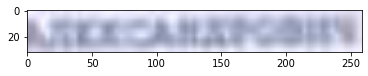

In [5]:
plt.imshow(train_ds[1][0])

(<matplotlib.image.AxesImage at 0x7f631d22bed0>, [14, 21, 8])

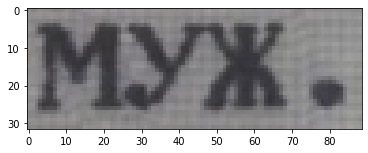

In [6]:
plt.imshow(train_ds[500][0]), train_ds[500][1]

**T** - input size

**N** - batch size

**C** - class count

## Model definition

In [7]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.linear = nn.Linear(nHidden * 2, nOut)

    def forward(self, input_batch):
        recurrent, _ = self.rnn(input_batch)
        T, b, h = recurrent.size()
        
        #print(T, b, h)
        
        
        t_rec = recurrent.view(T * b, h)
        
        #print(t_rec.shape)

        output = self.linear(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, input_channels_count, nclass, rnn_hidden_size, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        
        kernel_sizes_list = [3, 3, 3, 3, 3, 3, 2]
        paddings_list = [1, 1, 1, 1, 1, 1, 0]
        strides_list = [1, 1, 1, 1, 1, 1, 1]
        channels_list = [64, 128, 256, 256, 512, 512, 512]

        cnn_seq = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = input_channels_count if i == 0 else channels_list[i - 1]
            nOut = channels_list[i]
            
            cnn_seq.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, kernel_sizes_list[i], strides_list[i], paddings_list[i]))
            
            print(nIn, nOut, kernel_sizes_list[i], strides_list[i], paddings_list[i])
            
            if batchNormalization:
                cnn_seq.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn_seq.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn_seq.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn_seq.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64 (Channels, Height, Width)
        convRelu(1)
        cnn_seq.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn_seq.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn_seq.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn_module = cnn_seq
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, rnn_hidden_size, rnn_hidden_size),
            BidirectionalLSTM(rnn_hidden_size, rnn_hidden_size, nclass + 1))

    def forward(self, img_batch):
        # conv features
        conv = self.cnn_module(img_batch)
        batch_size, channels_count, img_height, img_width = conv.size()
        
        assert img_height == 1, "the height of conv must be 1"
        
        # print( batch_size, channels_count, img_height, img_width)
        
        conv = conv.squeeze(2)
        
        # print(conv.shape)
        
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        
        #print(conv.shape)

        # rnn features
        output = self.rnn(conv)

        return output

## Train loop

In [8]:
# # lists
# Levenshtein.distance(target[dataset.labels_list[label]], recognized_text)

In [8]:
def ctc_decode(model_answer: torch.Tensor, alphabet: str, blank_symb: int) -> list:    
    raw_text_ans = ['-' if item == blank_symb else alphabet[item - 1] for item in model_answer]
    
    prev_rep = 0
    
    result = [raw_text_ans[0]]
    
    for cur_pos in range(1, len(raw_text_ans)):        
        if raw_text_ans[cur_pos] != raw_text_ans[prev_rep]:
            result.append(raw_text_ans[cur_pos])
            prev_rep = cur_pos        
    
    return ''.join(filter(lambda x: x != '-', result))

In [9]:
blank_symb = 0

ctc_decode(torch.IntTensor([0, 1, 0, 1, 2, 3, 0, 0, 1, 2, 0, 2, 3, 1, 1, 1, 1, 0, 1, 2]), 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ', blank_symb)

'ААБВАББВААБ'

In [10]:
tensor_transformer = transforms.ToTensor()

def to_torch_collate_fn(batch):    
    images = list()
    labels = list()
    
    max_width = 0
    max_label_len = 0
    
    for temp_image, temp_label in batch:
        tensor_image = tensor_transformer(temp_image)
        
        max_width = max(tensor_image.shape[2], max_width)
        max_label_len = max(len(temp_label), max_label_len)
        #print(max_width)
        #print(tensor_image.shape[2])
        #print()
        
        images.append(tensor_image)
        labels.append(temp_label)
    
    #print(max_width)
    
    # Concatenate images
    for temp_ind in range(len(images)):
        # Resize to common size
        mod_image = torch.zeros((images[temp_ind].shape[0], images[temp_ind].shape[1], max_width))
        mod_image[:, :, :images[temp_ind].shape[2]] = images[temp_ind]
        images[temp_ind] = mod_image.unsqueeze(0)
        
        mod_label = torch.zeros((max_label_len))
        mod_label[:len(labels[temp_ind])] = torch.LongTensor(labels[temp_ind])
        labels[temp_ind] = mod_label.unsqueeze(0)
    
#     for image, label in zip(images, labels):
#         print(image.shape)
#         print(label.shape)
#         print('\n-----------------------------')
    
    #torch.cat([temp_image.unsqueeze(0) for temp_image in images], 0)
    
    return torch.cat(images, 0), torch.cat(labels, 0)

In [11]:
def train(model, train_loader, valid_loader, optimizer, loss_func, epoch_num, scheduler, alphabet):
    loss_history = list()
    valid_history = list()
    
    plt.figure(figsize=(20, 12))
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.title('Classifier loss')
    
    model.to(device)
    
    for epoch_step in range(epoch_num):
        model.train()
        temp_ctc_loss = 0#torch.zeros(1)
        
        for step, (imgs_batch, targets_batch) in enumerate(train_loader, 1):             
            imgs_batch, targets_batch = imgs_batch.to(device), targets_batch.to(device)
            
            cur_images = list()
            cur_targets = list()
            cur_target_lengths = list()

            cur_images = imgs_batch.to(device)
            cur_targets = targets_batch.to(device)
            #print([torch.count_nonzero(temp_target) for temp_target in targets_batch])
            cur_target_lengths = torch.LongTensor([torch.count_nonzero(temp_target) for temp_target in targets_batch]).to(device)
            
            #print(cur_images.shape)
            # Get model prediction
            logits = model(cur_images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)
            
            # Get lengths
            input_lengths = torch.LongTensor([logits.size(0)] * imgs_batch.size(0)).to(device)
            target_lengths = torch.flatten(cur_target_lengths)
            
            loss = loss_func(log_probs, cur_targets, input_lengths, cur_target_lengths)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            #print('Prev temp loss: ', temp_ctc_loss)
            temp_ctc_loss += loss.item()
            #print('Temp loss after batch: ', temp_ctc_loss)
            
        
        # Validation step
        model.eval()

        cur_epoch_lev_dist = 0

        for valid_step, (imgs_batch, targets_batch) in enumerate(valid_loader, 1):
            cur_images = imgs_batch.to(device)
            cur_targets = targets_batch.to(device)
            #print([torch.count_nonzero(temp_target) for temp_target in targets_batch])

            #print(cur_images.shape)
            # Get model prediction
            logits = model(cur_images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    #             print('Input shape: ', cur_images.shape)
    #             print('Answer shape: ', log_probs.shape)

            symb_predictions = torch.argmax(log_probs, dim=2)

    #             print('Symbols prediction size: ', symb_predictions.shape)
    #             print('Symbols prediction: ', symb_predictions)

    #             print(symb_predictions.shape)
    #             print(cur_targets.shape)



            # Calculate metric for every prediction in the batch
            for ind, word_tensor in enumerate(torch.transpose(symb_predictions, 0, 1), 0):
                temp_word = ctc_decode(word_tensor, alphabet, 0)
                temp_true_label = ctc_decode(cur_targets[ind].type(torch.IntTensor), alphabet, 0)

                #print(cur_targets[ind].type(torch.IntTensor))
                #print(word_tensor)

                #print(f'True label: {temp_true_label} Decoded: {temp_word}')
                cur_epoch_lev_dist += Levenshtein.ratio(temp_word, temp_true_label)

            # Normalization by words
            cur_epoch_lev_dist /= ind + 1
        # Normalization by the batches count
        cur_epoch_lev_dist /= valid_step

        valid_history.append(cur_epoch_lev_dist)
        
        if scheduler:
            scheduler.step()
        
        loss_history.append(temp_ctc_loss / len(train_loader))
        
        print(f'\n################################## Loss: {loss_history[-1]} Levenstein: {valid_history[-1]} ##################################')
    
    plt.plot(list(range(1, epoch_num + 1)), loss_history)
    
    return loss_history, valid_history

**img_height** = 32

**alphabet** = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ '

**rnn_hid_size** = 256

**epoch_num** = 30

**batch_size** = 16

**learning_rate** = 0.001

**OPTIMIZER**: ADAM(betas=(0.2, 0.7))

**scheduler** = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


*loss = 0.8438704433264556*

*leven = 0.16032089022830961*

In [34]:
RANDOM_SEED = 123

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)




torch.cuda.empty_cache()

# Dataset and model config
img_height = 32
alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ '
rnn_hid_size = 256
epoch_num = 30

train_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/train/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/train_mapping.csv', 
                            img_height=img_height,
                            alphabet=alphabet,
                            color_config='L',
                           )

test_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/test/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/test_mapping.csv', 
                            img_height=img_height,
                            alphabet=alphabet,
                            color_config='L'
                           )

train_loader = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True, collate_fn=to_torch_collate_fn, )
valid_loader = DataLoader(test_ds, batch_size=32, num_workers=2, shuffle=False, collate_fn=to_torch_collate_fn)

channels_count = 1 if train_ds.color_config == 'L' else 3
model = CRNN(input_channels_count=channels_count, imgH=img_height, nclass=len(alphabet), rnn_hidden_size=rnn_hid_size)

# Train config
learning_rate = 0.001
#params = [temp_param for temp_param in model.parameters() if temp_param.requires_grad]

loss_func = nn.CTCLoss(blank=len(alphabet))
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.2, 0.7), weight_decay=0.0001)
#scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=15)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.92)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, learning_rate, 2 * learning_rate, step_size_up=4, mode='triangular2')

1 64 3 1 1
64 128 3 1 1
128 256 3 1 1
256 256 3 1 1
256 512 3 1 1
512 512 3 1 1
512 512 2 1 0


In [35]:
# Model initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, np.sqrt(2))
        m.bias.data.fill_(0.0)
        print(m.weight[:3, :5, :3, :3])
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)    
    
model.apply(init_weights);

tensor([[[[-0.1194, -0.0253,  0.1029],
          [-0.0353, -0.0989, -0.1420],
          [ 0.0110,  0.1118, -0.0779]]],


        [[[-0.1051,  0.0480,  0.1420],
          [ 0.0884, -0.1268,  0.1171],
          [-0.0275,  0.0670, -0.0107]]],


        [[[ 0.0514,  0.0674,  0.1317],
          [ 0.0331,  0.0997,  0.0584],
          [ 0.1176, -0.1003, -0.0095]]]], grad_fn=<SliceBackward0>)
tensor([[[[ 0.0511, -0.0228, -0.0296],
          [-0.0545, -0.0127, -0.0555],
          [-0.0036, -0.0651, -0.0214]],

         [[ 0.0553, -0.0720,  0.0263],
          [-0.0154,  0.0577, -0.0602],
          [-0.0321,  0.0772,  0.0135]],

         [[ 0.0831, -0.0649,  0.0658],
          [-0.0462, -0.0343, -0.0353],
          [-0.0738,  0.0248,  0.0408]],

         [[-0.0077,  0.0597,  0.0363],
          [-0.0507,  0.0448, -0.0509],
          [ 0.0636, -0.0294, -0.0362]],

         [[-0.0317,  0.0621,  0.0173],
          [-0.0447, -0.0131,  0.0080],
          [-0.0654,  0.0162,  0.0791]]],


        [[[ 0.0


################################## Loss: 4.8900258673561945 Levenstein: 0.000197328712953713 ##################################

################################## Loss: 3.3791393085762307 Levenstein: 0.000197328712953713 ##################################

################################## Loss: 3.1639389682699135 Levenstein: 0.012811802710341458 ##################################

################################## Loss: 3.0547902363317982 Levenstein: 0.014514644422524205 ##################################

################################## Loss: 2.953688656842267 Levenstein: 0.000197328712953713 ##################################

################################## Loss: 3.2652113923320063 Levenstein: 0.03187368332471822 ##################################

################################## Loss: 2.9316717739458436 Levenstein: 0.05065275011628723 ##################################

################################## Loss: 2.8562154504987927 Levenstein: 0.0356122322312789 ########

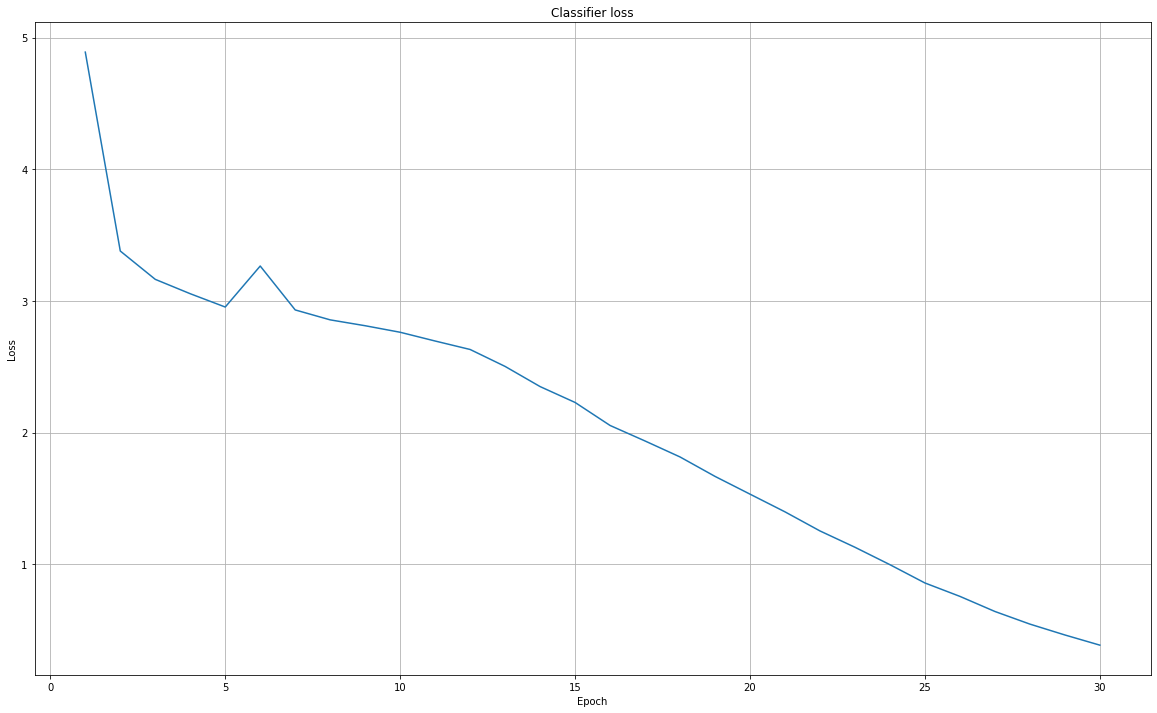

In [36]:
%%time
res = train(model, train_loader, valid_loader, optimizer, loss_func, epoch_num, scheduler, alphabet)

In [ ]:
def show_model_prediction(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, num_workers=4, shuffle=True, collate_fn=collate_fn)
    
    img_count = len(dataset)
    
    fig, axes = plt.subplots(img_count, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(24, img_count * 20))
    
    model.eval()
    
    img_convert = transforms.ToTensor()
    
    plt_ind = 0
    
    for img_batch, target_batch in data_loader:        
        prep_img_batch = list((img_convert(img).to(device) for img in img_batch))        
        
        outputs = model(prep_img_batch)

        
        ##########################
        for temp_image, mod_answer in zip(img_batch, outputs):

            kept_ind = torchvision.ops.nms(mod_answer['boxes'], mod_answer['scores'], 0.8)
        
            mod_answer = mod_answer[list(np.array(kept_ind.cpu()))]

            temp_image = np.array(temp_image)
            # Convert RGB to BGR 
            temp_image = temp_image[:, :, ::-1].copy() 

            for box_ind, (box, label) in enumerate(zip(mod_answer['boxes'], mod_answer['labels']), 1):
                # unpack the bounding box
                x0 = int(box[0])
                y0 = int(box[1])
                x1 = int(box[2])
                y1 = int(box[3])
                

                cv2.rectangle(temp_image, (x0, y0), (x1, y1), (0, 0, 255), 1)
                cv2.putText(temp_image, str(box_ind), ((x0 + x1) // 2, (y0 + y1) // 2), 
                            cv2.FONT_HERSHEY_COMPLEX, 0.3, (0, 255, 0))

                axes[plt_ind, 1].text(0, 1 - box_ind / len(mod_answer['boxes']), 
                                      f'{box_ind} -> {dataset.labels_list[label]}', fontsize=15, transform=axes[plt_ind, 1].transAxes)


            img_obj = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)

            img_width, img_height, _ = img_obj.shape

            cv2.resize(img_obj, (int(3 * img_width), int(3 * img_height)))

            axes[plt_ind, 0].imshow(img_obj)
            axes[plt_ind, 1].axis('off')
            plt_ind += 1
        
    plt.show()

In [ ]:
%%time
show_model_prediction(model.to(device), test_ds)